In [1]:
!wget https://www.dropbox.com/s/2xltmolfbfharri/apples_oranges.zip
!unzip apples_oranges.zip

--2024-03-18 15:41:29--  https://www.dropbox.com/s/2xltmolfbfharri/apples_oranges.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/2xltmolfbfharri/apples_oranges.zip [following]
--2024-03-18 15:41:30--  https://www.dropbox.com/s/raw/2xltmolfbfharri/apples_oranges.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfff4a0af530042768118c3376d.dl.dropboxusercontent.com/cd/0/inline/CPU7Spit4oVMtQQoyFVBgOOsgOyq-WsZJJXv7mc2SQdkpmar6RnhxxbKccKM8a9x6rxJZ9nSpEI9y0FpXF3LbXMP32gsCTgFwS8flfW3zEynkX12pZUFO0hK8lPoGEx8A-U01tSIt4jwJzV6LPrOvGQR/file# [following]
--2024-03-18 15:41:30--  https://ucfff4a0af530042768118c3376d.dl.dropboxusercontent.com/cd/0/inline/CPU7Spit4oVMtQQoyFVBgOOsgOyq-WsZJJXv7mc2SQdkpmar6RnhxxbKccKM8a9x6rxJZ9nSpEI9y0FpX

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import make_grid
from torchsummary import summary
from PIL import Image
!pip install torch-snippets
from torch_snippets import *


In [3]:
IMAGE_SIZE = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

data_transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.33)),
    transforms.RandomCrop((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

In [4]:
from torch.utils.data import Dataset,DataLoader

class CycleGANds(Dataset):
  def __init__(self,apples,oranges):
    self.apples = Glob(apples)
    self.oranges = Glob(oranges)

  def __len__(self):
    return max(len(self.apples),len(self.oranges))

  def __getitem__(self,ix):
    apple = self.apples[ix % len(self.apples)]
    orange = self.oranges[ix % len(self.oranges)]

    apple = Image.open(apple).convert('RGB')
    orange = Image.open(orange).convert('RGB')

    return apple,orange

  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self,batch):
    srcs , trgs = list(zip(*batch))
    srcs = torch.cat([data_transform(img)[None] for img in srcs],0).to(device).float()
    trgs = torch.cat([data_transform(img)[None] for img in trgs],0).to(device).float()

    return srcs.to(device),trgs.to(device)

In [17]:
trn_ds = CycleGANds('apples_train','oranges_train')
val_ds = CycleGANds('apples_test','oranges_test')

trn_dl = DataLoader(trn_ds,batch_size = 1 ,shuffle=True,collate_fn = trn_ds.collate_fn)
val_dl = DataLoader(val_ds,batch_size = 5 ,shuffle=True,collate_fn = val_ds.collate_fn)


In [18]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data,0.0,0.02)
    if hasattr(m,"bias") and m.bias is not None:
      torch.nn.init.constant_(m.bias.data , 0.0)

  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data,1.0,0.02)
    torch.nn.init.constant_(m.bias.data,0.0)


In [19]:
class ResBlock(nn.Module):
  def __init__(self,in_ch):
    super().__init__()

    self.block = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_ch,in_ch,3),

        nn.InstanceNorm2d(in_ch),
        nn.ReLU(inplace=True),

        nn.ReflectionPad2d(1),
        nn.Conv2d(in_ch,in_ch,3),
        nn.InstanceNorm2d(in_ch),
    )

  def forward(self,x):
    return x+self.block(x)

In [8]:
class GeneratorResidual(nn.Module):
  def __init__(self,num_residues=9):
    super().__init__()
    out_features = 64
    channels = 3

    model = [
        nn.ReflectionPad2d(3),
        nn.Conv2d(channels,out_features,7),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),
    ]


    in_features = out_features

    # Downsampling
    for _ in range(2):
      out_features *= 2
      model +=[
          nn.Conv2d(in_features,out_features,3,stride=2,padding=1),
          nn.InstanceNorm2d(out_features),
          nn.ReLU(inplace=True),
      ]
      in_features = out_features

    # Residual Blocks
    for _ in range(num_residues):
      model += [ResBlock(out_features)]

    # Upsampling
    for _ in range(2):
      out_features //=2
      model+=[
          nn.Upsample(scale_factor=2),
          nn.Conv2d(in_features,out_features,3,1,1),
          nn.InstanceNorm2d(out_features),
          nn.ReLU(inplace=True),
      ]
      in_features = out_features

    # Output Layer
    model += [nn.ReflectionPad2d(channels),
              nn.Conv2d(out_features,channels,7),
              nn.Tanh(),
              ]
    self.model = nn.Sequential(*model)
    self.apply(weights_init)

  def forward(self,x):
    return self.model(x)

In [9]:
x = GeneratorResidual()
x

GeneratorResidual(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5)

In [10]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    channels , height, width = 3 ,IMAGE_SIZE,IMAGE_SIZE

    def discriminator_block(in_ch,out_ch,normalize=True):
      layers =  [nn.Conv2d(in_ch,out_ch,4,2,1)]
      if normalize:
        layers.append(nn.InstanceNorm2d(in_ch))
      layers.append(nn.LeakyReLU(0.2,inplace = True))

      return layers

    self.model = nn.Sequential(
        *discriminator_block(channels,64,normalize=False),
        *discriminator_block(64,128),
        *discriminator_block(128,256),
        *discriminator_block(256,512),
        nn.ZeroPad2d((1,0,1,0)),
        nn.Conv2d(512,1,4,padding=1)
    )

    self.apply(weights_init)

  def forward(self,x):
    return self.model(x)

In [11]:
def generate_sample():
    data = next(iter(val_dl))
    G_AB.eval()
    G_BA.eval()

    real_A, real_B = data
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    show(image_grid.detach().cpu().permute(1,2,0).numpy(), sz=12)

In [12]:
def generator_train_step(Gs,optimizer,real_a,real_b):
  G_AB,G_BA = Gs

  optimizer.zero_grad()

  loss_id_a = criterion_identity(G_BA(real_a),real_a)
  loss_id_b = criterion_identity(G_AB(real_b),real_b)

  loss_id = (loss_id_a + loss_id_b) / 2

  fake_b = G_AB(real_a)
  loss_GAN_AB = criterion_gan(D_B(fake_b),torch.Tensor(np.ones((len(real_a),1,16,16))).to(device))
  fake_a = G_BA(real_b)
  loss_GAN_BA = criterion_gan(D_A(fake_a),torch.Tensor(np.ones((len(real_b),1,16,16))).to(device))

  loss_gan = (loss_GAN_AB+loss_GAN_BA) / 2

  recov_a = G_BA(fake_b)
  loss_cy_a = criterion_cycle(recov_a,real_a)
  recov_b = G_AB(fake_a)
  loss_cy_b = criterion_cycle(recov_b,real_b)
  loss_cy = ( loss_cy_a + loss_cy_b ) /2

  loss_G = loss_gan + lambda_cyc*loss_cy + lambda_id*loss_id
  loss_G.backward()
  optimizer.step()

  return loss_G,loss_id,loss_gan,loss_cy,loss_G,fake_a,fake_b

def discriminator_train_step(D, real_data, fake_data, optimizer):
    optimizer.zero_grad()
    loss_real = criterion_gan(D(real_data), torch.Tensor(np.ones((len(real_data), 1, 16, 16))).to(device))
    loss_fake = criterion_gan(D(fake_data.detach()), torch.Tensor(np.zeros((len(real_data), 1, 16, 16))).to(device))
    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer.step()
    return loss_D


In [13]:
device

'cuda'

In [14]:
import itertools

In [15]:
G_AB = GeneratorResidual().to(device)
G_BA = GeneratorResidual().to(device)

D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_gan = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(),G_BA.parameters()),lr=0.0002,betas = (0.5,0.999)
 )

optimizer_D_A = torch.optim.Adam(D_A.parameters(),lr=0.0002,betas = (0.5,0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(),lr=0.0002,betas = (0.5,0.999))

lambda_cyc , lambda_id = 10.0,5.0

In [ ]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
  N = len(trn_dl)
  for bx, batch in enumerate(trn_dl):
    real_a,real_b = batch

    loss_g,loss_id,loss_gan,loss_cy,loss_g,fake_a,fake_b = generator_train_step((G_AB,G_BA),optimizer_G,real_a,real_b)

    loss_d_a = discriminator_train_step(D_A,real_a,fake_a,optimizer_D_A)
    loss_d_b = discriminator_train_step(D_B,real_b,fake_b,optimizer_D_B)

    loss_d = (loss_d_a + loss_d_b) / 2
    log.record(epoch+(1+bx)/N,loss_d = loss_d.item(),
               loss_g = loss_g.item(),loss_gan = loss_gan.item(),
               loss_cy = loss_cy.item(),loss_id = loss_id.item(),
               end = '\r'
               )

    if bx%100 == 0 :
      generate_sample()

  log.report_avgs(epoch+1)


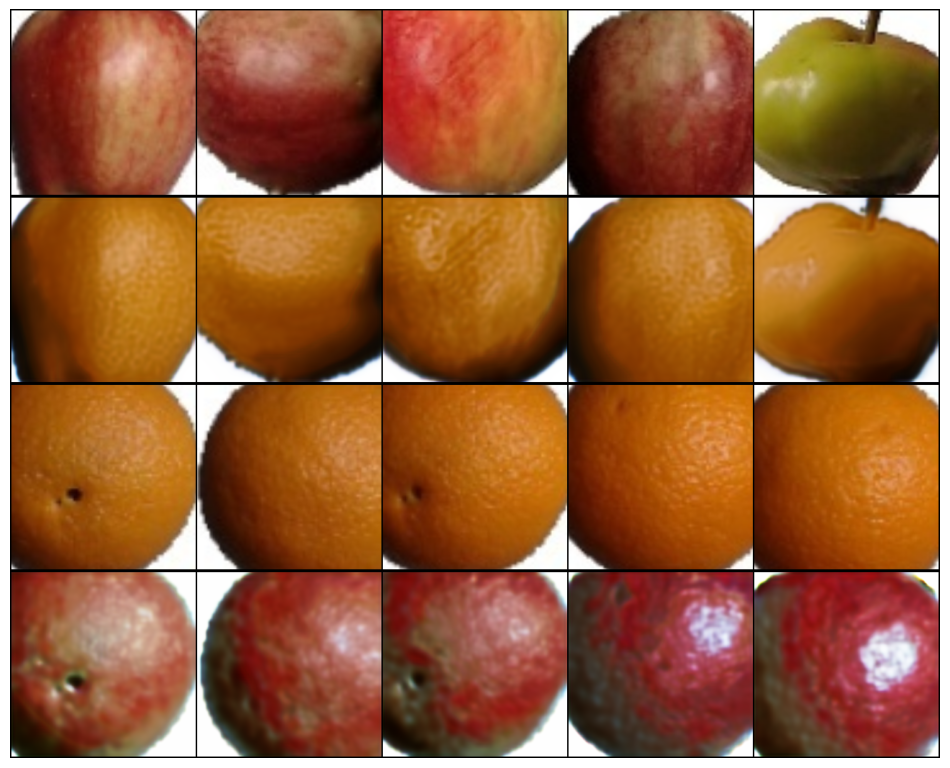

In [22]:
generate_sample()